In [3]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)


ResNet50 모델의 형태를 미리 선언

In [4]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [5]:
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=10, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 64 

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1) # 3 반복
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, 3)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

미리 학습시킨 parameter를 device로 로드

In [45]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 10, True).to(device) 
resnet50 = torch.load('resnet50.pt')

test data들을 DataLoader를 통해 적절한 형태로 가공

In [46]:
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

test_path = './test'

In [47]:
resize_trans = transforms.Compose([
	transforms.Resize((256,256)),
 	transforms.ToTensor()
])

resize_test = torchvision.datasets.ImageFolder(root = test_path, transform = resize_trans)

transform_test = transforms.Compose([
	transforms.Resize((256,256)),
 	transforms.CenterCrop(224),
	transforms.ToTensor(),
  	transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

testset = torchvision.datasets.ImageFolder(root = test_path, transform=transform_test)

testloader = DataLoader(testset, batch_size=4, shuffle=False)

test data들을 ResNet 모델에 적용시키는 함수

In [48]:
def get_representation(model, iterator):
  
  model.eval()
  
  outputs = []
  labels = []
  
  with torch.no_grad():
    for (x,y) in iterator:
      
      x = x.to(device)
      
      y_pred = model(x)
      
      outputs.append(y_pred.cpu())
      labels.append(y)
      
  outputs = torch.cat(outputs, dim = 0)
  labels = torch.cat(labels, dim = 0)
  
  return outputs, labels

In [49]:
testoutputs, testlabels = get_representation(resnet50, testloader)

In [50]:
import sklearn
from sklearn import manifold
import matplotlib.pyplot as plt

test output을 2차원 좌표평면에 출력하는 함수

In [51]:
def plot_representation(data, labels, classes=None,n_Images=None):
  if n_Images is not None:
    data = data[:n_Images]
    labels = labels[:n_Images]
    
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot(111)
  scatter = ax.scatter(data[:,0],data[:,1])

LinearDiscriminatAnalysis(LDA) method를 통해 test output을 2차원 데이터로 차원 축소
testoutputs(3차원) -> output_lda(2차원)

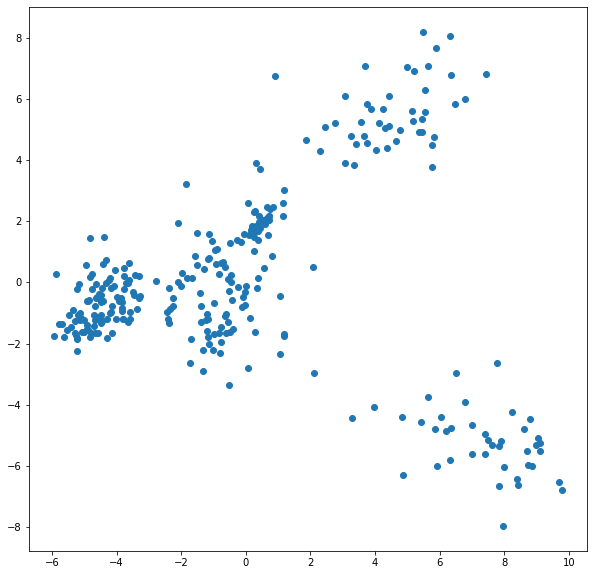

In [52]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

output_scaled = StandardScaler().fit_transform(testoutputs)
lda = LinearDiscriminantAnalysis(n_components = 2)
lda.fit(output_scaled, testlabels)

output_lda = lda.transform(output_scaled)
plot_representation(output_lda, testlabels)

t-SNE method를 통해 test output을 2차원으로 차원 축소
testoutputs(3) -> output_tsne(2)

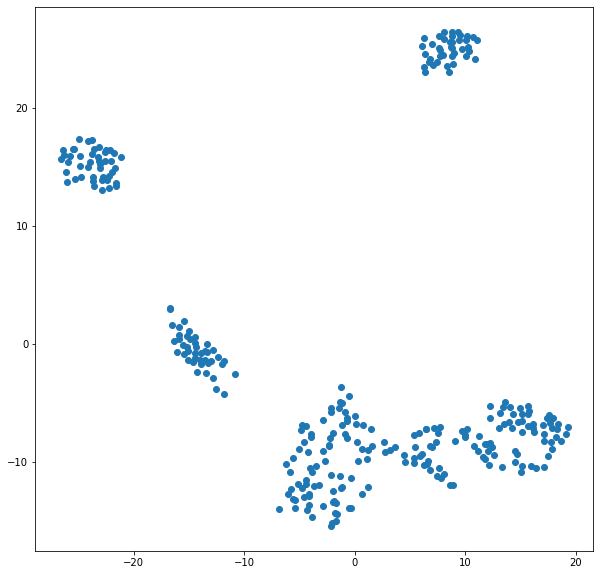

In [56]:
output_scaled = StandardScaler().fit_transform(testoutputs)
tsne = manifold.TSNE(n_components=2, learning_rate = 150)
output_tsne = tsne.fit_transform(output_scaled)
plot_representation(output_tsne, testlabels)

차원 축소한 두 데이터를 mean-shift clustering을 통해 clustering

Estimated clusters : 6


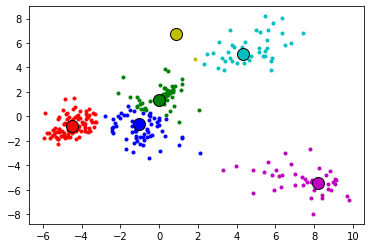

In [57]:
from typing import Text
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle

bandwidth = estimate_bandwidth(output_lda, quantile = .1)
ms = MeanShift(bandwidth = bandwidth + .2)
ms.fit(output_lda)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
clusters = labels.max()+1

color = cycle('rgbcmyk')
for i, col in zip(range(clusters),color):
  my_member = labels == i
  cluster_center = cluster_centers[i]
  plt.plot(output_lda[my_member,0], output_lda[my_member,1],col + '.')
  plt.plot(cluster_center[0], cluster_center[1], 'o', 
           markerfacecolor = col, markeredgecolor = 'k', markersize = 12)
print('Estimated clusters : %d' % clusters)
  
plt.show()

Estimated clusters : 7


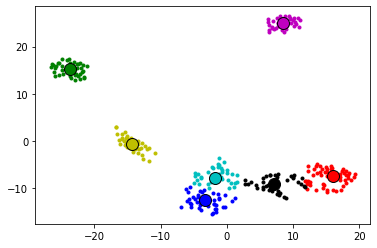

In [58]:
bandwidth = estimate_bandwidth(output_tsne, quantile = .1)
ms = MeanShift(bandwidth = bandwidth + .3)
ms.fit(output_tsne)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
clusters = labels.max()+1

color = cycle('rgbcmyk')
for i, col in zip(range(clusters),color):
  my_member = labels == i
  cluster_center = cluster_centers[i]
  plt.plot(output_tsne[my_member,0], output_tsne[my_member,1],col + '.')
  plt.plot(cluster_center[0], cluster_center[1], 'o', 
           markerfacecolor = col, markeredgecolor = 'k', markersize = 12)
print('Estimated clusters : %d' % clusters)
  
plt.show()